# Imports

In [ ]:
import os
from datetime import datetime, timedelta
import pandas as pd
from xgboost import XGBRegressor

import numpy as np

from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from xgboost import plot_importance
from matplotlib.patches import Patch

import hopsworks
from hsfs.feature import Feature

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Feature Stores Retrieval from Hopsworks

## Login & Retrieve All Feature Stores

In [732]:
project = hopsworks.login(engine="python", project='terahidro2003')
fs = project.get_feature_store()

2025-11-10 22:55:09,201 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-10 22:55:09,206 INFO: Initializing external client
2025-11-10 22:55:09,206 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-10 22:55:10,702 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286307


## Retrieve Air Quality and Wind Feature Stores

In [733]:
pm25_hourly_fg = fs.get_feature_group(
    name="pm25_hourly",
    version=1
)

wind_direction_hourly_fg = fs.get_feature_group(
    name="wind_direction_hourly",
    version=1
)

wind_speed_hourly_fg = fs.get_feature_group(
    name="wind_speed_hourly",
    version=1
)

air_temperature_hourly_fg = fs.get_feature_group(
    name="air_temperature_hourly",
    version=1
)

# Show what you actually got back for each FG call
print("pm_25_hourly_fg:", "Loaded" if pm25_hourly_fg is not None else "Not Loaded")
print("wind_direction_hourly_fg:", "Loaded" if wind_direction_hourly_fg is not None else "Not Loaded")
print("wind_speed_hourly_fg:", "Loaded" if wind_speed_hourly_fg is not None else "Not Loaded")
print("air_temperature_hourly_fg:", "Loaded" if air_temperature_hourly_fg is not None else "Not Loaded")

pm_25_hourly_fg: Loaded
wind_direction_hourly_fg: Loaded
wind_speed_hourly_fg: Loaded
air_temperature_hourly_fg: Loaded


# Feature View Creation

Join different feature groups (i.e., pm25, air speed and direction) together.

In [734]:
REGION = "west"

selected_features = pm25_hourly_fg.select(["pm25", "timestamp", "region"]).filter(pm25_hourly_fg.region == REGION).join(
    wind_direction_hourly_fg.select_features(), on=["region", "timestamp"]
).join(
    wind_speed_hourly_fg.select_features(), on=["region", "timestamp"]
).join(
    air_temperature_hourly_fg.select_features(), on=["region", "timestamp"]
)

2025-11-10 22:55:21,827 INFO: Using ['station_name', 'wind_direction_avg', 'wind_direction_std', 'reading_count', 'latitude', 'longitude', 'hour', 'day_of_week', 'day_of_month', 'month', 'year', 'is_weekend', 'wind_u', 'wind_v', 'wind_u_lag_1h', 'wind_v_lag_1h', 'wind_direction_lag_1h', 'wind_u_lag_2h', 'wind_v_lag_2h', 'wind_direction_lag_2h', 'wind_u_lag_3h', 'wind_v_lag_3h', 'wind_direction_lag_3h', 'wind_u_lag_6h', 'wind_v_lag_6h', 'wind_direction_lag_6h', 'wind_u_lag_12h', 'wind_v_lag_12h', 'wind_direction_lag_12h', 'wind_u_lag_24h', 'wind_v_lag_24h', 'wind_direction_lag_24h', 'wind_u_lag_48h', 'wind_v_lag_48h', 'wind_direction_lag_48h', 'wind_u_lag_72h', 'wind_v_lag_72h', 'wind_direction_lag_72h', 'wind_u_lag_168h', 'wind_v_lag_168h', 'wind_direction_lag_168h', 'wind_u_rolling_mean_6h', 'wind_v_rolling_mean_6h', 'direction_std_rolling_mean_6h', 'wind_u_rolling_mean_12h', 'wind_v_rolling_mean_12h', 'direction_std_rolling_mean_12h', 'wind_u_rolling_mean_24h', 'wind_v_rolling_mean_2

Create a feature view - selection of features from different feature groups that define I/O API of a model.

In [735]:
feature_view = fs.get_or_create_feature_view(
    name="air_quality_wind_temperature_features",
    version=1,
    description="Feature view with air quality and weather features (wind speed/direction and temperature)",
    labels=['pm25'],
    query=selected_features
)

2025-11-10 22:55:24,131 WARNING: Ambiguous features detected during query construction.The feature `year` is present in feature groups ['air_temperature_hourly version 1', 'wind_direction_hourly version 1', 'wind_speed_hourly version 1']. The feature `is_weekend` is present in feature groups ['air_temperature_hourly version 1', 'wind_direction_hourly version 1', 'wind_speed_hourly version 1']. The feature `latitude` is present in feature groups ['air_temperature_hourly version 1', 'wind_direction_hourly version 1', 'wind_speed_hourly version 1']. The feature `reading_count` is present in feature groups ['air_temperature_hourly version 1', 'wind_direction_hourly version 1', 'wind_speed_hourly version 1']. The feature `hour` is present in feature groups ['air_temperature_hourly version 1', 'wind_direction_hourly version 1', 'wind_speed_hourly version 1']. The feature `month` is present in feature groups ['air_temperature_hourly version 1', 'wind_direction_hourly version 1', 'wind_speed_h

# Splitting the Data into Train/Test Data Sets

In [775]:
start_date = "2025-10-24"

test_start = datetime.strptime(start_date, "%Y-%m-%d")
print("Test data starts from:", test_start.date())

Test data starts from: 2025-10-24


## Split data based on Start Date

In [776]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (15.07s) 
2025-11-10 23:19:59,253 WARNING: VersionWarning: Incremented version to `2`.

2025-11-10 23:19:59,254 INFO: Provenance cached data - overwriting last accessed/created training dataset from 1 to 2.


### Output Samples from each set

In [778]:
X_train.head(25000)

,timestamp,region,station_name,wind_direction_avg,wind_direction_std,reading_count,latitude,longitude,hour,day_of_week,...,air_temperature_hourly_air_temperature_rolling_min_24h,air_temperature_hourly_air_temperature_rolling_max_24h,air_temperature_hourly_air_temperature_rolling_mean_72h,air_temperature_hourly_air_temperature_rolling_std_72h,air_temperature_hourly_air_temperature_rolling_min_72h,air_temperature_hourly_air_temperature_rolling_max_72h,air_temperature_hourly_air_temperature_rolling_mean_168h,air_temperature_hourly_air_temperature_rolling_std_168h,air_temperature_hourly_air_temperature_rolling_min_168h,air_temperature_hourly_air_temperature_rolling_max_168h
0,2023-07-06 14:00:00+00:00,west,West Coast Highway,71.511831,0.162936,60.0,1.28100,103.75400,22.0,3.0,...,26.601695,29.881667,28.738677,1.720469,23.351724,32.676667,28.820132,1.460689,23.351724,32.676667
1,2023-07-08 01:00:00+00:00,west,West Coast Highway,282.600454,0.188241,60.0,1.28100,103.75400,9.0,5.0,...,26.151667,30.980000,28.169727,1.472115,23.351724,30.980000,28.842481,1.398900,23.351724,32.676667
2,2023-07-08 03:00:00+00:00,west,West Coast Highway,57.907624,0.753062,60.0,1.28100,103.75400,11.0,5.0,...,26.151667,30.980000,28.143129,1.446233,23.351724,30.980000,28.856003,1.393970,23.351724,32.676667
3,2023-07-10 04:00:00+00:00,west,West Coast Highway,266.063549,0.291230,60.0,1.28100,103.75400,12.0,0.0,...,25.350000,28.616667,28.423952,1.416124,25.350000,30.980000,28.578963,1.507865,23.351724,32.676667
4,2023-07-10 22:00:00+00:00,west,West Coast Highway,286.416402,0.210584,60.0,1.28100,103.75400,6.0,1.0,...,25.728333,29.000000,28.227729,1.321206,25.350000,30.938333,28.468767,1.533209,23.351724,32.676667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20159,2025-10-21 23:00:00+00:00,west,Tuas South Avenue 3,355.883635,0.131674,60.0,1.29377,103.61843,7.0,2.0,...,24.218333,30.018333,28.603866,1.621053,24.218333,30.833333,28.508906,1.588681,24.218333,32.160000
20160,2025-10-23 08:00:00+00:00,west,Tuas South Avenue 3,268.149986,0.017977,60.0,1.29377,103.61843,16.0,3.0,...,27.780000,30.523333,28.455671,1.433744,24.218333,30.523333,28.582183,1.557285,24.218333,32.160000
20161,2025-10-23 11:00:00+00:00,west,Tuas South Avenue 3,130.775275,0.981129,60.0,1.29377,103.61843,19.0,3.0,...,27.780000,30.523333,28.455509,1.433513,24.218333,30.523333,28.608304,1.570104,24.218333,32.160000
20162,2025-10-23 14:00:00+00:00,west,Tuas South Avenue 3,25.555928,0.137319,60.0,1.29377,103.61843,22.0,3.0,...,27.780000,30.523333,28.431088,1.418312,24.218333,30.523333,28.615843,1.571165,24.218333,32.160000


In [779]:
y_train

,pm25
0,2.0
1,3.0
2,4.0
3,9.0
4,4.0
...,...
20159,4.0
20160,6.0
20161,8.0
20162,5.0


In [ ]:
X_features = X_train.drop(columns=['timestamp'])
X_test_features = X_test.drop(columns=['timestamp'])
X_features.dropna(inplace=True)
mask = X_features.dropna().index
X_features = X_features.loc[mask].reset_index(drop=True)
# y_train = y_train.loc[mask].reset_index(drop=True)
X_features

,region,station_name,wind_direction_avg,wind_direction_std,reading_count,latitude,longitude,hour,day_of_week,day_of_month,...,air_temperature_hourly_air_temperature_rolling_min_24h,air_temperature_hourly_air_temperature_rolling_max_24h,air_temperature_hourly_air_temperature_rolling_mean_72h,air_temperature_hourly_air_temperature_rolling_std_72h,air_temperature_hourly_air_temperature_rolling_min_72h,air_temperature_hourly_air_temperature_rolling_max_72h,air_temperature_hourly_air_temperature_rolling_mean_168h,air_temperature_hourly_air_temperature_rolling_std_168h,air_temperature_hourly_air_temperature_rolling_min_168h,air_temperature_hourly_air_temperature_rolling_max_168h
0,west,West Coast Highway,71.511831,0.162936,60.0,1.28100,103.75400,22.0,3.0,6.0,...,26.601695,29.881667,28.738677,1.720469,23.351724,32.676667,28.820132,1.460689,23.351724,32.676667
1,west,West Coast Highway,282.600454,0.188241,60.0,1.28100,103.75400,9.0,5.0,8.0,...,26.151667,30.980000,28.169727,1.472115,23.351724,30.980000,28.842481,1.398900,23.351724,32.676667
2,west,West Coast Highway,57.907624,0.753062,60.0,1.28100,103.75400,11.0,5.0,8.0,...,26.151667,30.980000,28.143129,1.446233,23.351724,30.980000,28.856003,1.393970,23.351724,32.676667
3,west,West Coast Highway,266.063549,0.291230,60.0,1.28100,103.75400,12.0,0.0,10.0,...,25.350000,28.616667,28.423952,1.416124,25.350000,30.980000,28.578963,1.507865,23.351724,32.676667
4,west,West Coast Highway,286.416402,0.210584,60.0,1.28100,103.75400,6.0,1.0,11.0,...,25.728333,29.000000,28.227729,1.321206,25.350000,30.938333,28.468767,1.533209,23.351724,32.676667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19913,west,Tuas South Avenue 3,254.875560,0.103802,60.0,1.29377,103.61843,17.0,1.0,21.0,...,26.728333,30.293333,28.847245,1.489787,24.751667,31.835000,28.544144,1.467512,24.751667,32.160000
19914,west,Tuas South Avenue 3,355.883635,0.131674,60.0,1.29377,103.61843,7.0,2.0,22.0,...,24.218333,30.018333,28.603866,1.621053,24.218333,30.833333,28.508906,1.588681,24.218333,32.160000
19915,west,Tuas South Avenue 3,268.149986,0.017977,60.0,1.29377,103.61843,16.0,3.0,23.0,...,27.780000,30.523333,28.455671,1.433744,24.218333,30.523333,28.582183,1.557285,24.218333,32.160000
19916,west,Tuas South Avenue 3,130.775275,0.981129,60.0,1.29377,103.61843,19.0,3.0,23.0,...,27.780000,30.523333,28.455509,1.433513,24.218333,30.523333,28.608304,1.570104,24.218333,32.160000


# Modeling

In [808]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor(
    n_estimators=10000,
    learning_rate=0.02,
    max_depth=10,
    objective='reg:squarederror',
    tree_method='hist',
    sampling_method='uniform',
    eval_metric="mae",
    n_jobs=12,
    random_state=42
)

X_features = X_features.select_dtypes(include=["number"]).copy()
X_test_features = X_test_features.select_dtypes(include=["number"]).copy()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=12,
             num_parallel_tree=None, random_state=42, ...)

In [815]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

2025-11-10 23:47:02,830 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-11-10 23:47:02,831 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

MSE: 22.54137555260077
2025-11-10 23:47:02,832 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-11-10 23:47:02,832 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

R squared: 0.3885735545478646


In [816]:
df = y_test
df['predicted_pm25'] = y_pred

In [817]:
df['timestamp'] = X_test['timestamp']
df = df.sort_values(by=['timestamp'])
df.head(15)

,pm25,predicted_pm25,timestamp
2504,3.0,10.607846,2025-10-24 00:00:00+00:00
8759,3.0,8.467742,2025-10-24 01:00:00+00:00
13830,4.0,9.414841,2025-10-24 02:00:00+00:00
1255,6.0,10.380828,2025-10-24 03:00:00+00:00
16349,8.0,10.136713,2025-10-24 04:00:00+00:00
11282,6.0,9.383078,2025-10-24 05:00:00+00:00
17633,11.0,7.903798,2025-10-24 06:00:00+00:00
17634,6.0,9.408047,2025-10-24 07:00:00+00:00
20163,12.0,8.718317,2025-10-24 08:00:00+00:00
10028,8.0,9.815593,2025-10-24 09:00:00+00:00


In [818]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

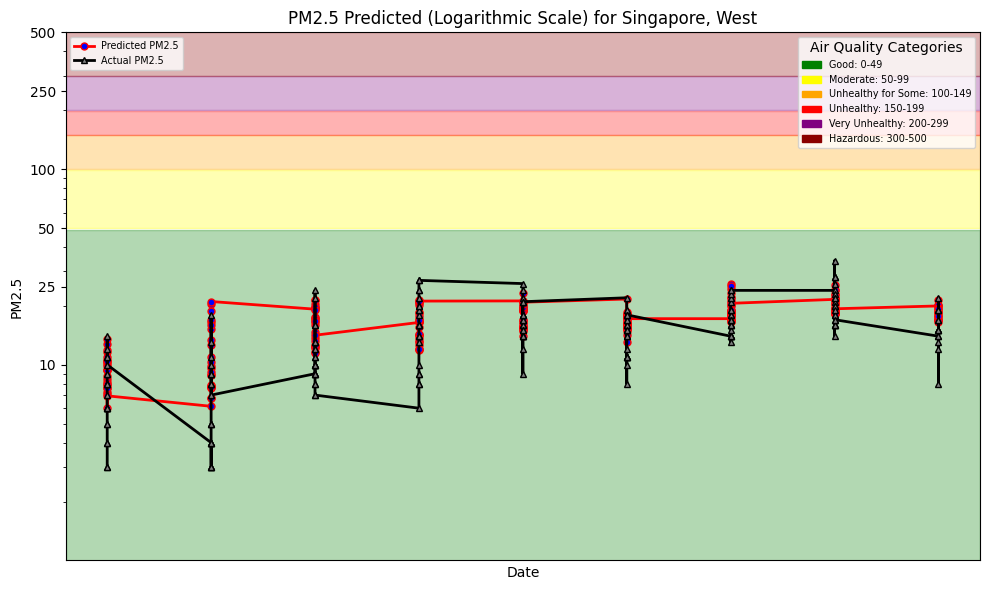

In [819]:
def plot_air_quality_forecast(city: str, street: str, df: pd.DataFrame, file_path: str, hindcast=False):
    fig, ax = plt.subplots(figsize=(10, 6))

    day = pd.to_datetime(df['timestamp']).dt.date
    # Plot each column separately in matplotlib
    ax.plot(day, df['predicted_pm25'], label='Predicted PM2.5', color='red', linewidth=2, marker='o', markersize=5, markerfacecolor='blue')

    # Set the y-axis to a logarithmic scale
    ax.set_yscale('log')
    ax.set_yticks([0, 10, 25, 50, 100, 250, 500])
    ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
    ax.set_ylim(bottom=1)

    # Set the labels and title
    ax.set_xlabel('Date')
    ax.set_title(f"PM2.5 Predicted (Logarithmic Scale) for {city}, {street}")
    ax.set_ylabel('PM2.5')

    colors = ['green', 'yellow', 'orange', 'red', 'purple', 'darkred']
    labels = ['Good', 'Moderate', 'Unhealthy for Some', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
    ranges = [(0, 49), (50, 99), (100, 149), (150, 199), (200, 299), (300, 500)]
    for color, (start, end) in zip(colors, ranges):
        ax.axhspan(start, end, color=color, alpha=0.3)

    # Add a legend for the different Air Quality Categories
    patches = [Patch(color=colors[i], label=f"{labels[i]}: {ranges[i][0]}-{ranges[i][1]}") for i in range(len(colors))]
    legend1 = ax.legend(handles=patches, loc='upper right', title="Air Quality Categories", fontsize='x-small')

    # Aim for ~10 annotated values on x-axis, will work for both forecasts ans hindcasts
    if len(df.index) > 11:
        every_x_tick = len(df.index) / 10
        ax.xaxis.set_major_locator(MultipleLocator(every_x_tick))

    plt.xticks(rotation=45)

    if hindcast == True:
        ax.plot(day, df['pm25'], label='Actual PM2.5', color='black', linewidth=2, marker='^', markersize=5, markerfacecolor='grey')
        legend2 = ax.legend(loc='upper left', fontsize='x-small')
        ax.add_artist(legend1)

    # Ensure everything is laid out neatly
    plt.tight_layout()

    # # Save the figure, overwriting any existing file with the same name
    plt.savefig(file_path)
    return plt

file_path = images_dir + "/pm25_hindcast.png"
plt = plot_air_quality_forecast('Singapore', 'West', df, file_path, hindcast=True) 
plt.show()

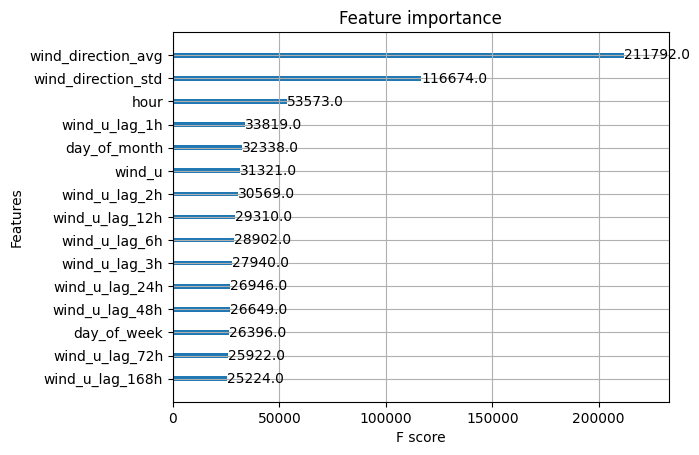

In [820]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor, max_num_features=15)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()